<a href="https://colab.research.google.com/github/risker93/Hello_World/blob/main/doitkaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
item_categories = pd.read_csv('/content/drive/MyDrive/data/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/data/items.csv')
sales_train = pd.read_csv('/content/drive/MyDrive/data/sales_train.csv') #학습데이터
sample_submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
shops = pd.read_csv('/content/drive/MyDrive/data/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/data/test.csv')#테스트 데이터


In [ ]:
raw_data = sales_train

In [ ]:
#1.train에 중복값 제거 (raw_data 모든 컬럼값이 동일한 value를 삭제)
# drop_duplicates
subset= ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(raw_data.duplicated(subset=subset).value_counts())
raw_data.drop_duplicates(subset=subset, inplace=True)
# 2935849 - 2935825 = 24개의 중복데이터 삭제

False    2935825
True          24
dtype: int64


In [ ]:
#2.test에 있는 세일즈수만 예측하면되기때문에 train에서 test에 없는 상품 제거
#test_shops = test.shop_id.unique()
#test_items = test.item_id.unique()
#raw_data = raw_data[raw_data.shop_id.isin(test_shops)]
#raw_data = raw_data[raw_data.item_id.isin(test_items)]
#raw_data.shape
# 기존2935825에서1224429으로 절반 이상 데이터 드랍

In [ ]:
# item(22169개의 아이템)과 item_cate(83개의 카테고리) 의 데이터 그룹 생성
# item_categories_name 안에 또 큰 범주의 카테고리가 있다.
# pickup first-category name
items_g = item_categories['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_categories['item_group'] = pd.Categorical(items_g).codes
item_c = pd.merge(item_categories, item_categories.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

item_c.head()

,item_category_name,item_category_id,item_group_x,item_group_y
0,PC - Гарнитуры/Наушники,0,0,0
1,Аксессуары - PS2,1,1,1
2,Аксессуары - PS3,2,1,1
3,Аксессуары - PS4,3,1,1
4,Аксессуары - PSP,4,1,1


In [ ]:
item_c = item_c.drop('item_group_y',axis=1)

In [ ]:
item_c = item_c.drop('item_category_name',axis=1)

In [ ]:
item_c.columns = ['item_category_id','item_group']

In [ ]:
item_c

,item_category_id,item_group
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
79,79,12
80,80,12
81,81,13
82,82,13


In [ ]:
# 상점 이름의 따른 분류
# 상점도 이름안에 큰 범주가 있다. city로 변경
city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


In [ ]:
shops = shops.drop('shop_name', axis=1)

In [ ]:
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
itemsinfo = pd.merge(items, item_c)

In [ ]:
itemsinfo

,item_name,item_id,item_category_id,item_group
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,7
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,7
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,7
3,***КОРОБКА (СТЕКЛО) D,4,40,7
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,7
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,14
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,14
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,14
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,14


In [ ]:
len(raw_data)

2935825

In [ ]:
df = pd.merge(raw_data,itemsinfo)

In [ ]:
len(df)

2935825

In [ ]:
df = pd.merge(df,shops)

In [ ]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_group,city
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,7,30
1,16.05.2013,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,9,30
2,26.01.2013,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,9,30
3,09.01.2013,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,9,30
4,24.02.2013,1,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,9,30


In [ ]:
df = df.drop('item_name',axis=1)

In [ ]:
#df = df.drop('item_group',axis=1)

In [ ]:
df = df.drop('item_price',axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935825 entries, 0 to 2935824
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int64  
 2   shop_id           int64  
 3   item_id           int64  
 4   item_cnt_day      float64
 5   item_category_id  int64  
 6   item_group        int8   
 7   city              int8   
dtypes: float64(1), int64(4), int8(2), object(1)
memory usage: 162.4+ MB


In [ ]:
df.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_cnt_day        0
item_category_id    0
item_group          0
city                0
dtype: int64

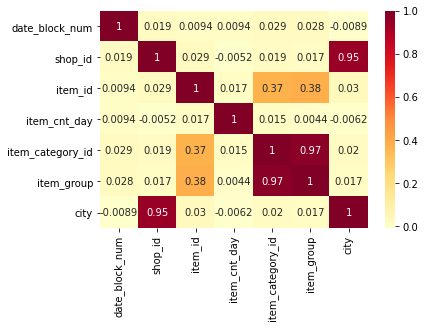

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='YlOrRd')

In [ ]:
#df.columns

In [ ]:
#sns.jointplot(x='item_price', y='item_cnt_day', data=df)

In [ ]:
#sns.jointplot(x='item_category_id', y='item_cnt_day', data=df)

In [ ]:
#sns.jointplot(x='item_id', y='item_cnt_day', data=df)

In [ ]:
#sns.jointplot(x='shop_id', y='item_cnt_day', data=df)

In [ ]:
#df.columns

In [ ]:
#sns.boxplot(x='shop_name', y='item_cnt_day', data=df)

In [ ]:
#sns.boxplot(x='date', y='item_cnt_day', data=df)

In [ ]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day',
       'item_category_id', 'item_group', 'city'],
      dtype='object')

In [ ]:
#df2 = df.drop(['item_price','date_block_num'],axis=1)

In [ ]:
df

,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
0,02.01.2013,0,59,22154,1.0,37,7,30
1,16.05.2013,4,59,2573,1.0,55,9,30
2,26.01.2013,0,59,2574,1.0,55,9,30
3,09.01.2013,0,59,2574,1.0,55,9,30
4,24.02.2013,1,59,2574,1.0,55,9,30
...,...,...,...,...,...,...,...,...
2935820,28.10.2015,33,55,1819,3.0,31,5,27
2935821,29.10.2015,33,55,1819,1.0,31,5,27
2935822,24.10.2015,33,55,2390,1.0,31,5,27
2935823,01.10.2015,33,55,1935,1.0,31,5,27


In [ ]:
#print(df['item_price'].quantile(0.95))
#print(df['item_price'].quantile(0.005))

In [ ]:
#df2 = df2[(df2['item_price'] < df2['item_price'].quantile(0.95)) & (df2['item_price'] > df2['item_price'].quantile(0.005))]

In [ ]:
#df2['item_price'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff803bca810>,
      dtype=object)

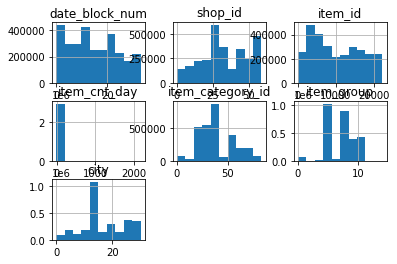

In [ ]:
df.hist()

In [ ]:
df2 = df

In [ ]:
df2= df2[(df2['item_cnt_day'] < df2['item_cnt_day'].quantile(0.95))]

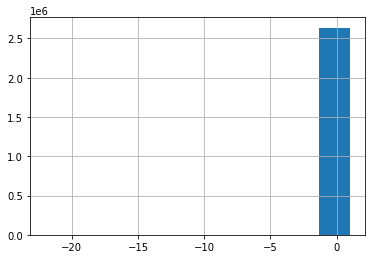

In [ ]:
df2['item_cnt_day'].hist()

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])

In [ ]:
df3 = df2.set_index(['date'])

In [ ]:
df3 = df3.sort_index()

In [ ]:
df3 = df3.reset_index()

In [ ]:
df3.index.name = 'ID'

In [ ]:
df3.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
ID,,,,,,,,
0,2013-01-01,0,54,9910,1.0,40,7,26
1,2013-01-01,0,54,15779,1.0,55,9,26
2,2013-01-01,0,54,15552,1.0,37,7,26
3,2013-01-01,0,15,14931,1.0,69,10,9
4,2013-01-01,0,51,7198,1.0,69,10,24


In [ ]:
df3 = df3.rename_axis('ID').reset_index()

In [ ]:
df3.head()

,ID,date,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
0,0,2013-01-01,0,54,9910,1.0,40,7,26
1,1,2013-01-01,0,54,15779,1.0,55,9,26
2,2,2013-01-01,0,54,15552,1.0,37,7,26
3,3,2013-01-01,0,15,14931,1.0,69,10,9
4,4,2013-01-01,0,51,7198,1.0,69,10,24


In [ ]:
df3 = df3.set_index('date')

In [ ]:
df3.head()

,ID,date_block_num,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
date,,,,,,,,
2013-01-01,0,0,54,9910,1.0,40,7,26
2013-01-01,1,0,54,15779,1.0,55,9,26
2013-01-01,2,0,54,15552,1.0,37,7,26
2013-01-01,3,0,15,14931,1.0,69,10,9
2013-01-01,4,0,51,7198,1.0,69,10,24


In [ ]:
dfformerge = df3[['item_id','item_category_id','item_group']]

In [ ]:
dfgormerge2 = df3[['shop_id','city']]

In [ ]:
dfformerge

,item_id,item_category_id,item_group
date,,,
2013-01-01,9910,40,7
2013-01-01,15779,55,9
2013-01-01,15552,37,7
2013-01-01,14931,69,10
2013-01-01,7198,69,10
...,...,...,...
2015-12-10,5816,23,5
2015-12-10,12935,37,7
2015-12-10,14801,40,7


In [ ]:
dfgormerge2

,shop_id,city
date,,
2013-01-01,54,26
2013-01-01,54,26
2013-01-01,54,26
2013-01-01,15,9
2013-01-01,51,24
...,...,...
2015-12-10,15,9
2015-12-10,53,25
2015-12-10,31,13


In [ ]:
df4 = df3.groupby(by=['shop_id','item_id'])['item_cnt_day'].resample('M').sum()

In [ ]:
#df7 = df3.groupby(by=['shop_id','item_id'])['item_price'].resample('M').sum()

In [ ]:
#dfprice = pd.DataFrame(df7)

In [ ]:
#dfprice = dfprice.reset_index()

In [ ]:
df4

shop_id  item_id  date      
0        31       2013-02-28    5.0
         32       2013-01-31    2.0
                  2013-02-28    2.0
                  2013-03-31    0.0
                  2013-04-30    0.0
                               ... 
59       22167    2014-02-28    0.0
                  2014-03-31    0.0
                  2014-04-30    0.0
                  2014-05-31    0.0
                  2014-06-30    1.0
Name: item_cnt_day, Length: 3818913, dtype: float64

In [ ]:
df5 = pd.DataFrame(df4)

In [ ]:
df5 = df5.reset_index()

In [ ]:
df5.head()

,shop_id,item_id,date,item_cnt_day
0,0,31,2013-02-28,5.0
1,0,32,2013-01-31,2.0
2,0,32,2013-02-28,2.0
3,0,32,2013-03-31,0.0
4,0,32,2013-04-30,0.0


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818913 entries, 0 to 3818912
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   shop_id       int64         
 1   item_id       int64         
 2   date          datetime64[ns]
 3   item_cnt_day  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 116.5 MB


In [ ]:
items = items.drop('item_name',axis=1)

In [ ]:
df6 = pd.merge(df5, items, how='left', left_on='item_id',right_on='item_id')

In [ ]:
df6

,shop_id,item_id,date,item_cnt_day,item_category_id
0,0,31,2013-02-28,5.0,37
1,0,32,2013-01-31,2.0,40
2,0,32,2013-02-28,2.0,40
3,0,32,2013-03-31,0.0,40
4,0,32,2013-04-30,0.0,40
...,...,...,...,...,...
3818908,59,22167,2014-02-28,0.0,49
3818909,59,22167,2014-03-31,0.0,49
3818910,59,22167,2014-04-30,0.0,49
3818911,59,22167,2014-05-31,0.0,49


In [ ]:
dform_du = dfformerge.drop_duplicates(subset = 'item_id')

In [ ]:
dform_du

,item_id,item_category_id,item_group
date,,,
2013-01-01,9910,40,7
2013-01-01,15779,55,9
2013-01-01,15552,37,7
2013-01-01,14931,69,10
2013-01-01,7198,69,10
...,...,...,...
2015-12-08,368,45,8
2015-12-08,367,45,8
2015-12-08,252,45,8


In [ ]:
dform_du2 = dfgormerge2.drop_duplicates(subset = 'shop_id')

In [ ]:
dform_du2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-01-01 to 2015-10-18
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   shop_id  60 non-null     int64
 1   city     60 non-null     int8 
dtypes: int64(1), int8(1)
memory usage: 1020.0 bytes


In [ ]:
df6= pd.merge(df5, dform_du, how='left', left_on='item_id', right_on='item_id')

In [ ]:
df6= pd.merge(df6, dform_du2, how='left', left_on='shop_id', right_on='shop_id')

In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818913 entries, 0 to 3818912
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   shop_id           int64         
 1   item_id           int64         
 2   date              datetime64[ns]
 3   item_cnt_day      float64       
 4   item_category_id  int64         
 5   item_group        int8          
 6   city              int8          
dtypes: datetime64[ns](1), float64(1), int64(3), int8(2)
memory usage: 182.1 MB


In [ ]:
#dfsummonth = pd.merge(df5, dfprice)

In [ ]:
#dfsummonth

In [ ]:
#itemsinfo.head()

In [ ]:
#newitemsinfo = itemsinfo.drop(['item_name','item_category_name'],axis=1)

In [ ]:
#newitemsinfo.head()

In [ ]:
#mergetest = pd.merge(df5, newitemsinfo)

In [ ]:
#mergetest2 = pd.merge(df5, newitemsinfo, how='left',left_on='item_id', right_on='item_id')

In [ ]:
#mergetest3 = pd.merge(df5, newitemsinfo, how='left',left_on='item_id', right_on='item_id' )

In [ ]:
#mergetest3.head()

In [ ]:
df6['date'] = pd.to_datetime(df6['date'])

In [ ]:
df6=df6.set_index('date')

In [ ]:
df6 = df6.sort_index()

In [ ]:
df6= df6.reset_index()

In [ ]:
df6 = df6.rename_axis('ID').reset_index()

In [ ]:
df6

,ID,date,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
0,0,2013-01-31,31,8423,2.0,40,7,13
1,1,2013-01-31,43,5592,2.0,5,1,19
2,2,2013-01-31,43,5591,1.0,5,1,19
3,3,2013-01-31,25,14050,3.0,40,7,13
4,4,2013-01-31,54,7739,1.0,30,5,26
...,...,...,...,...,...,...,...,...
3818908,3818908,2015-12-31,21,20338,1.0,72,10,13
3818909,3818909,2015-12-31,55,19383,1.0,31,5,27
3818910,3818910,2015-12-31,46,19058,1.0,40,7,21
3818911,3818911,2015-12-31,46,19116,1.0,40,7,21


In [ ]:
df6 = df6.drop('date', axis=1)

In [ ]:
df6

,ID,shop_id,item_id,item_cnt_day,item_category_id,item_group,city
0,0,31,8423,2.0,40,7,13
1,1,43,5592,2.0,5,1,19
2,2,43,5591,1.0,5,1,19
3,3,25,14050,3.0,40,7,13
4,4,54,7739,1.0,30,5,26
...,...,...,...,...,...,...,...
3818908,3818908,21,20338,1.0,72,10,13
3818909,3818909,55,19383,1.0,31,5,27
3818910,3818910,46,19058,1.0,40,7,21
3818911,3818911,46,19116,1.0,40,7,21


In [ ]:
df6 = df6.drop('index', axis=1)

KeyError: ignored

In [ ]:
#mergetest3.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df6)
X_scaled = scaler.transform(df6)
X_scaled = pd.DataFrame(X_scaled, index=df6.index, columns =df6.columns)

In [ ]:
X_scaled.head()

In [ ]:
X_scaled.info()

In [ ]:
#X = X_scaled.drop(['item_cnt_day'],axis=1)
#y = df6['item_cnt_day']

In [ ]:
len(X_scaled)

In [ ]:
len(y)

In [ ]:
#정규화를 하지않고 돌려본다
y = df6.loc[:,'item_cnt_day']
X = df6.drop(['item_cnt_day'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
from xgboost import XGBRegressor
model_reg = XGBRegressor()
model_reg.fit(X_train, y_train)

[00:12:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
pred = model_reg.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(sqrt(mean_squared_error(y_test, pred)))

0.7092832354828211
1.0174396802771253


In [ ]:
pred.mean()

0.68657446

In [ ]:
# 주요하게 적용하는 변수를 판단
from xgboost import plot_importance

import matplotlib.pyplot as plt

%matplotlib inline

plot_importance(model_reg, height=0.9)

In [ ]:
test.head()

In [ ]:
#testmerge = pd.merge(test, newitemsinfo, how='left', left_on='item_id', right_on='item_id')

In [ ]:
#testmerge

In [ ]:
#mergefortest = df3.drop(['shop_id', 'item_category_id','item_cnt_day','ID'],axis=1)

In [ ]:
#mergefortest

In [ ]:
#df3.head()

In [ ]:
evalcsv = pd.read_csv('/content/forsubmission.csv')

In [ ]:
eval = evalcsv

In [ ]:
eval =pd.merge(eval, itemsinfo,how='left',left_on='item_id',right_on='item_id')

In [ ]:
eval =pd.merge(eval, shops,how='left',left_on='shop_id',right_on='shop_id')

In [ ]:
eval = eval.drop('item_name',axis=1)

In [ ]:
test.head()

In [ ]:
eval = pd.merge(test, items, how='left', left_on='item_id',right_on='item_id')

In [ ]:
eval.head()

,ID,shop_id,item_id,item_price,item_category_id,item_group,city
0,0.0,5.0,5037.0,2599.0,19,5,3
1,1.0,5.0,5320.0,0.0,55,9,3
2,2.0,5.0,5233.0,1199.0,19,5,3
3,3.0,5.0,5232.0,599.5,23,5,3
4,4.0,5.0,5268.0,0.0,20,5,3


In [ ]:
eval = eval.drop('item_price',axis=1)

In [ ]:
pred = model_reg.predict(eval)

In [ ]:
pred.mean()

1.0542748

In [ ]:
adfadsf

In [ ]:
items.head()


In [ ]:
evalcsv.head()

In [ ]:
evalcsv = pd.merge(evalcsv, items, how='left',left_on='item_id',right_on='item_id')

In [ ]:
evalcsv =evalcsv.drop('item_name',axis=1)

In [ ]:
submission =pd.DataFrame(pred)

In [ ]:
submission_copy = submission.rename_axis('ID').reset_index()

In [ ]:
submission_copy

,ID,0
0,0,1.625745
1,1,1.170108
2,2,1.571877
3,3,1.538465
4,4,1.444967
...,...,...
214195,214195,0.682318
214196,214196,0.752480
214197,214197,0.685352
214198,214198,0.734361


In [ ]:
submission_copy.columns = ['ID', 'item_cnt_month']

In [ ]:
submission_copy

,ID,item_cnt_month
0,0,1.625745
1,1,1.170108
2,2,1.571877
3,3,1.538465
4,4,1.444967
...,...,...
214195,214195,0.682318
214196,214196,0.752480
214197,214197,0.685352
214198,214198,0.734361


In [ ]:
submission_copy.mean()

ID                107099.50000
item_cnt_month         1.05436
dtype: float64

In [ ]:
submission_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 2.5 MB


In [ ]:

submission_copy['item_cnt_month'] = submission_copy['item_cnt_month'].astype(float)
submission_copy.to_csv('XG_submission3.csv',index=False)

In [ ]:
items.head()

In [ ]:
len(test)